In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Bidirectional, Input, Concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, Normalizer

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [3]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [4]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [131]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
# df['Population'] = np.array([6.4 *(10**9) for x in range(len(df))])

df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


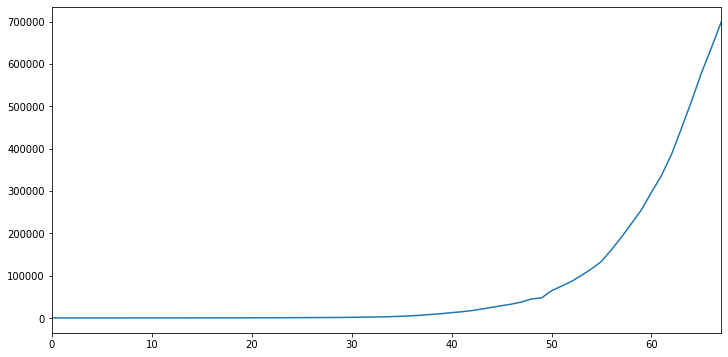

In [132]:
df['Confirmed'].plot(figsize=(12,6))

In [133]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 18

In [134]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [135]:
training_set = df[:train_index]

In [136]:
# sc = MinMaxScaler()
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
# sc = Normalizer()
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))

In [137]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [138]:
print(X_train.shape, y_train.shape)

(36, 18, 1) (36,)


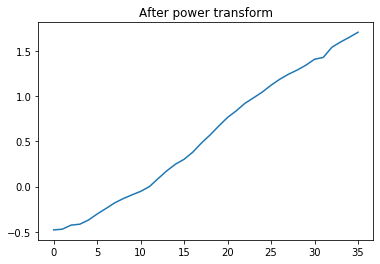

In [139]:
X_train[0]
plt.plot(y_train)
plt.title('After power transform')

plt.show()

In [140]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
54,2020-03-17,116044,55
55,2020-03-18,133719,56
56,2020-03-19,161344,57
57,2020-03-20,190785,58
58,2020-03-21,223091,59


In [141]:
real_conf = testing_set['Confirmed'].values

In [142]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [143]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [144]:
# inputs
# total

In [145]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))

In [146]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [147]:
model = Sequential()

model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

# population_input_layer = Input(shape=(1,))
# population_dense = Dense(32)(population_input_layer)

# input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
# lstm = LSTM(256)(input_layer)
# merge = Concatenate(axis=-1)([lstm,population_dense])
# dropout_lstm = Dropout(0.2)(merge)
# confirmed = Dense(1)(dropout_lstm)

# model = Model([input_layer,population_input_layer], confirmed)
# model.summary()

# model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)


In [148]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
plat = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.7)
cb = [checkpoint, plat]

In [149]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
#                     validation_data = (X_test, Y_test),
                    validation_split = 0.1)

Train on 32 samples, validate on 4 samples
Epoch 1/200
32/32 [==============================] - 1s 20ms/step - loss: 0.5146 - val_loss: 0.6407
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 0.4069 - val_loss: 0.4397
Epoch 3/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3145 - val_loss: 0.2518
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 0.2788 - val_loss: 0.1779
Epoch 5/200
32/32 [==============================] - 0s 2ms/step - loss: 0.2444 - val_loss: 0.1670
Epoch 6/200
32/32 [==============================] - 0s 2ms/step - loss: 0.1869 - val_loss: 0.1465
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 0.1691 - val_loss: 0.0972
Epoch 8/200
32/32 [==============================] - 0s 2ms/step - loss: 0.1440 - val_loss: 0.0174
Epoch 9/200
32/32 [==============================] - 0s 2ms/step - loss: 0.1129 - val_loss: 0.1022
Epoch 10/200
32/32 [==============================] - 0s 2ms/step

Epoch 72/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0092

Epoch 00072: ReduceLROnPlateau reducing learning rate to 6.782229866075795e-06.
Epoch 73/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0092
Epoch 74/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0092
Epoch 75/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0092
Epoch 76/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0093

Epoch 00076: ReduceLROnPlateau reducing learning rate to 4.747560842588427e-06.
Epoch 77/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0093
Epoch 78/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0094
Epoch 79/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0095
Epoch 80/200
32/32 [==================

Epoch 140/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0102

Epoch 00140: ReduceLROnPlateau reducing learning rate to 1.577753501180723e-08.
Epoch 141/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0102
Epoch 142/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0102
Epoch 143/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0102
Epoch 144/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0102

Epoch 00144: ReduceLROnPlateau reducing learning rate to 1.1044275005644976e-08.
Epoch 145/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0102
Epoch 146/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0102
Epoch 147/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0102
Epoch 148/200
32/32 [========

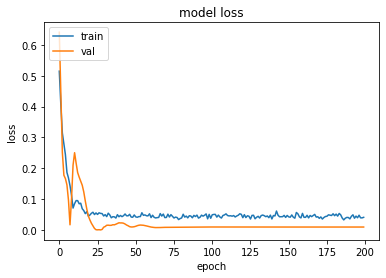

In [150]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [151]:
model.load_weights("model.h5")

In [152]:
predicted_conf = model.predict(X_test)

In [153]:
# predicted_conf=pd.DataFrame(predicted_conf)
X_test[0]

array([[0.57259898],
       [0.67194317],
       [0.76565637],
       [0.83900455],
       [0.92200102],
       [0.98341353],
       [1.04657611],
       [1.12206572],
       [1.18793975],
       [1.24327849],
       [1.28922113],
       [1.34299932],
       [1.40890447],
       [1.42893952],
       [1.54237153],
       [1.60029679],
       [1.65215716],
       [1.70768343]])

In [154]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
# real_conf

array([[117934.766],
       [137401.38 ],
       [159528.78 ],
       [185204.5  ],
       [215311.84 ],
       [250402.1  ],
       [290406.88 ],
       [335578.8  ],
       [385763.03 ],
       [440927.62 ],
       [502002.88 ],
       [569558.25 ],
       [643573.56 ],
       [722610.2  ]], dtype=float32)

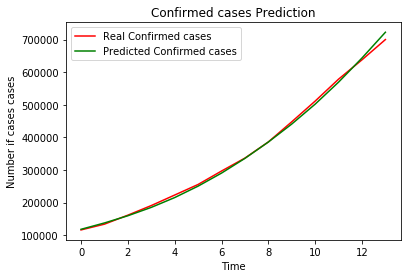

In [155]:
# plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

In [156]:
pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
real_conf = np.array(real_conf)
# pred_conf
real_conf

array([116044, 133719, 161344, 190785, 223091, 255518, 296737, 336454,
       385992, 447809, 511394, 578707, 637995, 700167], dtype=int64)

In [157]:

print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1)))))

RMSLE =  0.020801660358249874


# For each country

In [569]:
pop = pd.read_csv('datasets\population_data.csv')
pop.head()

,Name,Population,Type
0,Alabama,4888000.0,Province/State
1,Alaska,737438.0,Province/State
2,Alberta,4371000.0,Province/State
3,Anhui,62000000.0,Province/State
4,Arizona,7172000.0,Province/State


In [570]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [571]:
country ='Portugal'

In [572]:
temp = df_c[df_c['Country/Region'] == country]
temp = temp[temp['Confirmed'] > 0].fillna(0)
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,Country/Region,Lat,Long,Date,Confirmed
7075,Portugal,39.3999,-8.2245,2020-03-02,2
7253,Portugal,39.3999,-8.2245,2020-03-03,2
7431,Portugal,39.3999,-8.2245,2020-03-04,5
7609,Portugal,39.3999,-8.2245,2020-03-05,8
7787,Portugal,39.3999,-8.2245,2020-03-06,13


In [574]:
N = int(pop[pop['Name'] == country]['Population'])
N

10196709